In [110]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from langdetect import detect
import spacy
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import nltk
from collections import Counter

In [2]:
parent_folder = "./DevGPT"

folder_names = ["snapshot_20230803", "snapshot_20230824", "snapshot_20230914",
                "snapshot_20230810", "snapshot_20230831", "snapshot_20231012",
                "snapshot_20230727", "snapshot_20230817", "snapshot_20230907"]

# Define the patterns to identify different types of files
patterns = ["_issue_sharings.json", "_hn_sharings.json", "_discussion_sharings.json", "_commit_sharings.json", "_pr_sharings.json", "_file_sharings.json"]

# Initialize dataframes for each type of file
issue_sharings_df = pd.DataFrame()
hn_sharings_df = pd.DataFrame()
discussions_sharings_df = pd.DataFrame()
commit_sharings_df = pd.DataFrame()
pr_sharings_df = pd.DataFrame()
file_sharings_df = pd.DataFrame()

# Iterate through folders and files
for folder_name in folder_names:
    full_folder_path = os.path.join(parent_folder, folder_name)
    for file_name in os.listdir(full_folder_path):
        file_path = os.path.join(full_folder_path, file_name)
        
        # Check if the file name contains any of the specified patterns
        for pattern in patterns:
            if pattern in file_name:
                # Create custom location string for reading CSV files
                custom_location = f"{file_path}"
                print(custom_location)
                # Read CSV file into a dataframe
                df = pd.read_json(custom_location)
                
                # Assign the dataframe to the corresponding variable based on the pattern
                if "_issue_sharings.json" in pattern:
                    issue_sharings_df = pd.concat([issue_sharings_df, df], ignore_index=True)
                elif "_hn_sharings.json" in pattern:
                    hn_sharings_df = pd.concat([hn_sharings_df, df], ignore_index=True)
                elif "_discussion_sharings.json" in pattern:
                    discussions_sharings_df = pd.concat([discussions_sharings_df, df], ignore_index=True)
                elif "_commit_sharings.json" in pattern:
                    commit_sharings_df = pd.concat([commit_sharings_df, df], ignore_index=True)
                elif "_pr_sharings.json" in pattern:
                    pr_sharings_df = pd.concat([pr_sharings_df, df], ignore_index=True)
                elif "_file_sharings.json" in pattern:
                    file_sharings_df = pd.concat([file_sharings_df, df], ignore_index=True)


./DevGPT/snapshot_20230803/20230803_095317_commit_sharings.json
./DevGPT/snapshot_20230803/20230803_094811_discussion_sharings.json
./DevGPT/snapshot_20230803/20230803_094705_issue_sharings.json
./DevGPT/snapshot_20230803/20230803_093947_pr_sharings.json
./DevGPT/snapshot_20230803/20230803_105332_hn_sharings.json
./DevGPT/snapshot_20230803/20230803_103605_file_sharings.json
./DevGPT/snapshot_20230824/20230824_101836_issue_sharings.json
./DevGPT/snapshot_20230824/20230824_102000_discussion_sharings.json
./DevGPT/snapshot_20230824/20230824_102435_commit_sharings.json
./DevGPT/snapshot_20230824/20230824_111114_file_sharings.json
./DevGPT/snapshot_20230824/20230824_100450_pr_sharings.json
./DevGPT/snapshot_20230824/20230824_112153_hn_sharings.json
./DevGPT/snapshot_20230914/20230914_104122_file_sharings.json
./DevGPT/snapshot_20230914/20230914_083202_commit_sharings.json
./DevGPT/snapshot_20230914/20230914_080417_issue_sharings.json
./DevGPT/snapshot_20230914/20230914_080601_discussion_sha

In [3]:
def extract_json_to_columns(df):
    df = pd.DataFrame(df.Sources.tolist())
    df = pd.concat([df, pd.DataFrame(df.ChatgptSharing.str[0].tolist()).add_prefix("CGS_")], axis=1)
    return df

In [4]:
issue_sharings_df = extract_json_to_columns(issue_sharings_df)
hn_sharings_df = extract_json_to_columns(hn_sharings_df)
discussions_sharings_df = extract_json_to_columns(discussions_sharings_df)
commit_sharings_df = extract_json_to_columns(commit_sharings_df)
pr_sharings_df = extract_json_to_columns(pr_sharings_df)
file_sharings_df = extract_json_to_columns(file_sharings_df)

#### Remove Null values from Conversations

In [5]:
issue_sharings_df['CGS_Conversations'] = issue_sharings_df.CGS_Conversations.fillna('').apply(list)
hn_sharings_df['CGS_Conversations'] = hn_sharings_df.CGS_Conversations.fillna('').apply(list)
discussions_sharings_df['CGS_Conversations'] = discussions_sharings_df.CGS_Conversations.fillna('').apply(list)
commit_sharings_df['CGS_Conversations'] = commit_sharings_df.CGS_Conversations.fillna('').apply(list)
pr_sharings_df['CGS_Conversations'] = pr_sharings_df.CGS_Conversations.fillna('').apply(list)
file_sharings_df['CGS_Conversations'] = file_sharings_df.CGS_Conversations.fillna('').apply(list)

#### Extract Prompts and Answers from Conversations

##### Helper Function

In [6]:
# Function to extract Prompts and Answers
def extract_prompts_and_answers(conversations):
    prompts = []
    answers = []

    if conversations:
        for i, conv in enumerate(conversations):
                prompt = conv.get("Prompt", "")
                answer = conv.get("Answer", "")
                prompts.append(prompt)
                answers.append(answer)
    
    conv_len = len(prompts) + len(answers)
    return pd.Series({"Prompts": prompts, "Answers": answers, "Conversation_Length": conv_len})

##### Alternate

In [7]:
# Expands Prompts and Answers to seperate columns for each record
# pd.concat([hn_sharings_df, pd.DataFrame(hn_sharings_df.Prompts.tolist(), index = hn_sharings_df.index).add_prefix("Prompt_")], axis=1)

##### Sol 2

In [8]:
# Expands Prompts and answers to create multiple rows with one Prompt and Answer Pair each.
# result = []
# for idx, row in hn_sharings_df.iterrows():
#     for dct in row['Conversations']:
#         for col in list(set(hn_sharings_df.columns) - set(["Conversations", "ChatgptSharing", "HTMLContent"])):
#             dct[col] = row[col]
#         result.append(dct)

# result_df = pd.DataFrame(result)

##### Apply on all dataframes

In [9]:
issue_sharings_df[["Prompts", "Answers", "Conversation_Length"]] = issue_sharings_df.CGS_Conversations.apply(extract_prompts_and_answers)
hn_sharings_df[["Prompts", "Answers", "Conversation_Length"]] = hn_sharings_df.CGS_Conversations.apply(extract_prompts_and_answers)
discussions_sharings_df[["Prompts", "Answers", "Conversation_Length"]] = discussions_sharings_df.CGS_Conversations.apply(extract_prompts_and_answers)
commit_sharings_df[["Prompts", "Answers", "Conversation_Length"]] = commit_sharings_df.CGS_Conversations.apply(extract_prompts_and_answers)
pr_sharings_df[["Prompts", "Answers", "Conversation_Length"]] = pr_sharings_df.CGS_Conversations.apply(extract_prompts_and_answers)
file_sharings_df[["Prompts", "Answers", "Conversation_Length"]] = file_sharings_df.CGS_Conversations.apply(extract_prompts_and_answers)

### Duplicate Records Cleaning

In [10]:
def dedupe_data(data, identifier='CGS_URL'):
    return data.loc[data.groupby(identifier).Conversation_Length.idxmax()]

In [11]:
issue_sharings_final_df = dedupe_data(issue_sharings_df)
hn_sharings_final_df = dedupe_data(hn_sharings_df)
discussions_sharings_final_df = dedupe_data(discussions_sharings_df)
commit_sharings_final_df = dedupe_data(commit_sharings_df)
pr_sharings_final_df = dedupe_data(pr_sharings_df)
file_sharings_final_df = dedupe_data(file_sharings_df)

In [12]:
print(f"issue_sharings - Original: {issue_sharings_df.shape}, Final: {issue_sharings_final_df.shape}")
print(f"hn_sharings - Original: {hn_sharings_df.shape}, Final: {hn_sharings_final_df.shape}")
print(f"discussions_sharings - Original: {discussions_sharings_df.shape}, Final: {discussions_sharings_final_df.shape}")
print(f"commit_sharings - Original: {commit_sharings_df.shape}, Final: {commit_sharings_final_df.shape}")
print(f"pr_sharings - Original: {pr_sharings_df.shape}, Final: {pr_sharings_final_df.shape}")
print(f"file_sharings - Original: {file_sharings_df.shape}, Final: {file_sharings_final_df.shape}")

issue_sharings - Original: (3081, 28), Final: (516, 28)
hn_sharings - Original: (1633, 26), Final: (235, 26)
discussions_sharings - Original: (398, 29), Final: (62, 29)
commit_sharings - Original: (3245, 25), Final: (672, 25)
pr_sharings - Original: (1693, 34), Final: (269, 34)
file_sharings - Original: (8664, 29), Final: (1668, 29)


In [13]:
file_sharings_df.columns

Index(['Type', 'URL', 'ObjectSha', 'FileName', 'FilePath', 'Author', 'Content',
       'RepoName', 'RepoLanguage', 'CommitSha', 'CommitMessage', 'AuthorAt',
       'CommitAt', 'ChatgptSharing', 'CGS_URL', 'CGS_Mention', 'CGS_Status',
       'CGS_DateOfConversation', 'CGS_DateOfAccess', 'CGS_Title',
       'CGS_NumberOfPrompts', 'CGS_TokensOfPrompts', 'CGS_TokensOfAnswers',
       'CGS_Model', 'CGS_Conversations', 'CGS_HTMLContent', 'Prompts',
       'Answers', 'Conversation_Length'],
      dtype='object')

#### Make final Dataframe

In [14]:
columns_to_keep = [
    'Type', 'RepoLanguage', 'CGS_URL', 'CGS_Status', 'CGS_DateOfConversation', 'CGS_DateOfAccess', 
    'CGS_Title', 'CGS_NumberOfPrompts', 'CGS_TokensOfPrompts', 
    'CGS_TokensOfAnswers', 'CGS_Model', 
    'Prompts', 'Answers', 'Conversation_Length'
]

In [15]:
hn_sharings_final_df['RepoLanguage'] = ''

In [16]:
final_df = pd.concat(
    [issue_sharings_final_df[columns_to_keep], 
     hn_sharings_final_df[columns_to_keep], 
     discussions_sharings_final_df[columns_to_keep], 
     commit_sharings_final_df[columns_to_keep], 
     pr_sharings_final_df[columns_to_keep], 
     file_sharings_final_df[columns_to_keep]
    ], 
    axis=0,
    ignore_index=True,
    
)

In [17]:
final_df = final_df.drop_duplicates(subset="CGS_URL", keep="first")

In [18]:
final_df.drop(final_df[final_df.Conversation_Length == 0].index, inplace=True)

In [19]:
final_df.isna().sum().sort_values(ascending=False)

RepoLanguage              341
Type                        0
CGS_URL                     0
CGS_Status                  0
CGS_DateOfConversation      0
CGS_DateOfAccess            0
CGS_Title                   0
CGS_NumberOfPrompts         0
CGS_TokensOfPrompts         0
CGS_TokensOfAnswers         0
CGS_Model                   0
Prompts                     0
Answers                     0
Conversation_Length         0
dtype: int64

In [20]:
final_df.loc[final_df.CGS_Title == '']

,Type,RepoLanguage,CGS_URL,CGS_Status,CGS_DateOfConversation,CGS_DateOfAccess,CGS_Title,CGS_NumberOfPrompts,CGS_TokensOfPrompts,CGS_TokensOfAnswers,CGS_Model,Prompts,Answers,Conversation_Length
367,issue,Java,https://chat.openai.com/share/b508ddd3-af83-42...,200,"July 8, 2023",2023-08-03 09:39:55.655581,,3.0,36.0,931.0,,[How to add a java class in a generic containe...,[To add a Java class in a generic container fr...,6
606,hacker news,,https://chat.openai.com/share/6478dcdd-98d3-44...,200,"September 12, 2023",2023-09-14 10:42:30.379231,,1.0,15.0,618.0,Default,[Discuss the last 20 years of Windows UI frame...,[Certainly! Let's walk through the last two de...,2
1731,pull request,TypeScript,https://chat.openai.com/share/e5d50333-2d70-4c...,200,"September 5, 2023",2023-09-14 07:39:48.425320,,1.0,10.0,250.0,Default,[transifex github integration sync goes both w...,"[As of my last update in September 2021, Trans...",2


In [21]:
final_df.to_csv("Final_data.csv")

In [32]:
(final_df[~(final_df.RepoLanguage == '')].groupby("RepoLanguage", dropna=True).CGS_URL.nunique().sort_values(ascending=False) / final_df.shape[0] * 100).reset_index()

,RepoLanguage,CGS_URL
0,CSS,29.423660
1,Python,10.852713
2,HTML,6.572295
3,JavaScript,4.347826
4,TypeScript,3.572632
...,...,...
66,Nim,0.033704
67,Nix,0.033704
68,Nunjucks,0.033704
69,Objective-C,0.033704


In [43]:
def detect_language(text):
    text = ' '.join(text)
    try:
        return detect(text)
    except:
        return 'Error'

In [44]:
final_df['language'] = final_df['Prompts'].apply(detect_language)

In [46]:
final_df.language.value_counts()

en       2672
ja         83
es         39
zh-cn      37
pt         26
de         18
fr         18
ko         16
ca          9
vi          8
no          5
ru          5
da          5
id          4
nl          4
et          3
ro          2
it          2
cy          2
sv          2
pl          1
sk          1
af          1
cs          1
tr          1
tl          1
sw          1
Name: language, dtype: int64

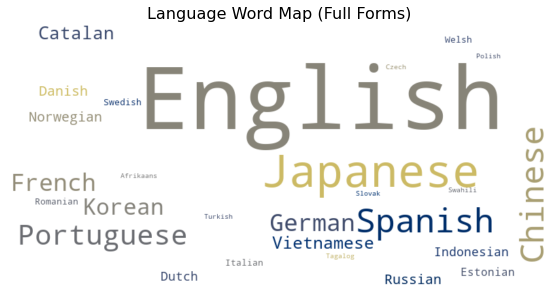

In [50]:
# Mapping language codes to their full forms for the word cloud
language_full_forms = {
    'en': 'English', 'ja': 'Japanese', 'es': 'Spanish', 'zh-cn': 'Chinese', 
    'pt': 'Portuguese', 'de': 'German', 'fr': 'French', 'ko': 'Korean', 'vi': 'Vietnamese', 
    'ca': 'Catalan', 'af': 'Afrikaans', 'ro': 'Romanian', 'no': 'Norwegian', 'ru': 'Russian', 
    'da': 'Danish', 'sv': 'Swedish', 'cy': 'Welsh', 'et': 'Estonian', 'nl': 'Dutch', 
    'id': 'Indonesian', 'tr': 'Turkish', 'pl': 'Polish', 'sq': 'Albanian', 'sk': 'Slovak', 
    'cs': 'Czech', 'it': 'Italian', 'sw': 'Swahili','tl': 'Tagalog'
}

# Updating the data for the word cloud with full forms
wordcloud_data_full_forms = {language_full_forms[lang]: count * 10 for lang, count in final_df.language.value_counts().items()}

# Creating the word cloud with full forms
wordcloud_full_forms = WordCloud(width=800, height=400, background_color='white',colormap='cividis').generate_from_frequencies(wordcloud_data_full_forms)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_full_forms, interpolation='bilinear')
plt.axis('off')
plt.title('Language Word Map (Full Forms)', fontsize=16)
plt.show()


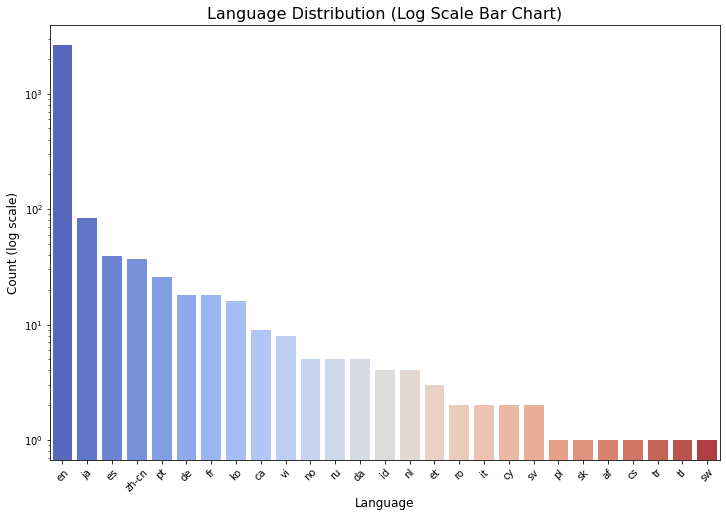

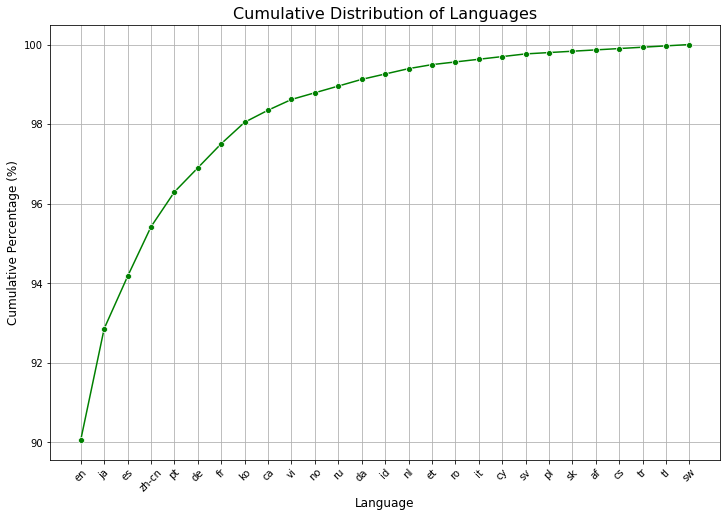

In [54]:
# Log Scale Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(x=list(final_df.language.value_counts().keys()), y=list(final_df.language.value_counts().values), palette='coolwarm')
plt.yscale('log')
plt.title('Language Distribution (Log Scale Bar Chart)', fontsize=16)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Count (log scale)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Cumulative Distribution Plot
# Sorting the languages by count
sorted_counts = dict(sorted(final_df.language.value_counts().items(), key=lambda item: item[1], reverse=True))

# Calculating the cumulative distribution
cumulative_distribution = np.cumsum(list(sorted_counts.values())) / sum(sorted_counts.values()) * 100

plt.figure(figsize=(12, 8))
sns.lineplot(x=list(sorted_counts.keys()), y=cumulative_distribution, marker='o', color='green')
plt.title('Cumulative Distribution of Languages', fontsize=16)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Cumulative Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [89]:
english_df = final_df[final_df.language == 'en']

In [101]:
english_df.isnull().sum()

Type                      0
RepoLanguage              0
CGS_URL                   0
CGS_Status                0
CGS_DateOfConversation    0
CGS_DateOfAccess          0
CGS_Title                 0
CGS_NumberOfPrompts       0
CGS_TokensOfPrompts       0
CGS_TokensOfAnswers       0
CGS_Model                 0
Prompts                   0
Answers                   0
Conversation_Length       0
language                  0
dtype: int64

In [91]:
english_df.loc[:, 'RepoLanguage'] = english_df['RepoLanguage'].replace('',np.nan,regex = True)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/3638901101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df.loc[:, 'RepoLanguage'] = english_df['RepoLanguage'].replace('',np.nan,regex = True)


In [93]:
english_df.loc[:, 'CGS_Model'] = english_df['CGS_Model'].replace('',np.nan,regex = True)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/1117997730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df.loc[:, 'CGS_Model'] = english_df['CGS_Model'].replace('',np.nan,regex = True)


In [94]:
english_df.loc[:, 'CGS_Title'] = english_df['CGS_Title'].replace('',np.nan,regex = True)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/248438442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df.loc[:, 'CGS_Title'] = english_df['CGS_Title'].replace('',np.nan,regex = True)


In [96]:
english_df['CGS_Model'].fillna('Default', inplace=True)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/3291195931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['CGS_Model'].fillna('Default', inplace=True)


In [98]:
english_df['CGS_Title'].fillna('NA', inplace=True)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/2231334434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['CGS_Title'].fillna('NA', inplace=True)


In [100]:
english_df['RepoLanguage'].fillna('NA', inplace=True)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/2989583493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['RepoLanguage'].fillna('NA', inplace=True)


### Basic Sentiment Analysis

#### Preprocessing

In [105]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_df(text):
    text = ' '.join(text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Replace newlines and tabs with a space
    text = text.replace('\\n', ' ').replace('\t', ' ')
    # Remove non-alphabetic characters
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()

    # Apply spaCy model for lemmatization and stop word removal
    doc = nlp(text)
    clean_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])

    return clean_text.strip()

In [106]:
english_df['CleanPrompts'] = english_df['Prompts'].apply(clean_df)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/483241532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['CleanPrompts'] = english_df['Prompts'].apply(clean_df)


In [108]:
english_df.head()

,Type,RepoLanguage,CGS_URL,CGS_Status,CGS_DateOfConversation,CGS_DateOfAccess,CGS_Title,CGS_NumberOfPrompts,CGS_TokensOfPrompts,CGS_TokensOfAnswers,CGS_Model,Prompts,Answers,Conversation_Length,language,CleanPrompts
0,issue,Swift,https://chat.openai.com/share/00078bea-9349-47...,200,"August 4, 2023",2023-08-24 10:13:24.517188,Set Reconciliation Protocol Overview,10.0,3674.0,4652.0,Default,[I'm trying to understand this set reconciliat...,[Alright! Let's start by breaking down the int...,20,en,m try understand set reconciliation protocol ...
2,issue,PHP,https://chat.openai.com/share/00d4058e-bbd1-46...,200,"August 14, 2023",2023-08-24 10:14:09.721718,Confirm Dialog on Popstate,2.0,47.0,381.0,Default,[Is it possible to show a confirm dialog when ...,"[Yes, it is possible to achieve a similar beha...",4,en,possible confirm dialog user navigate away his...
3,issue,C#,https://chat.openai.com/share/01b0088b-4b8b-4e...,200,"August 15, 2023",2023-08-24 10:10:34.002928,Sync vs. Async Approaches,1.0,25.0,345.0,Default,[HI! What better in C# for Task class. Use `Re...,"[In C#, when dealing with asynchronous code an...",2,en,hi well c task class use result ge...
4,issue,Python,https://chat.openai.com/share/0233d7e5-7286-44...,200,"September 2, 2023",2023-09-14 07:55:42.761020,Setting up MongoDB in Flask,3.0,925.0,1130.0,Default,[reference flask app ./app.py:\nfrom flask imp...,"[To set up MongoDB in your Flask app, you'll n...",6,en,reference flask app app py \n flask import ...
5,issue,Go,https://chat.openai.com/share/02a1ba5b-217f-42...,200,"August 19, 2023",2023-08-24 10:09:48.108851,gRPC Server for Web,2.0,51.0,1191.0,Default,"[i have a grpc server, how can i modify the se...",[To enable gRPC communication over HTTP/1.1 or...,4,en,grpc server modify server support http ...


In [111]:
# Step 1: Count word frequencies
word_counts = Counter()
english_df['CleanPrompts'].str.split().apply(word_counts.update)

# Convert Counter object to a dictionary
frequency_dict = dict(word_counts)

In [112]:
sorted_frequency_dict = dict(sorted(frequency_dict.items(), key=lambda item: item[1], reverse=True))

In [113]:
sorted_frequency_dict = {word: count for word, count in sorted_frequency_dict.items() if len(word) > 1}
# Parameters: percentage of words to remove from top and bottom
top_percent = 5  # for example, top 5%
bottom_percent = 5  # for example, bottom 5%

# Number of words to remove from top and bottom
num_words = len(sorted_frequency_dict)
top_words_to_remove = int(num_words * top_percent / 100)
bottom_words_to_remove = int(num_words * bottom_percent / 100)

# Removing top N% high-frequency words
for word in list(sorted_frequency_dict.keys())[:top_words_to_remove]:
    del sorted_frequency_dict[word]

# Removing bottom N% low-frequency words
for word in list(sorted_frequency_dict.keys())[-bottom_words_to_remove:]:
    del sorted_frequency_dict[word]

# sorted_frequency_dict now has the words removed as per the criteria


In [114]:
def filter_words(text):
    # Split the text into words and filter out words not in the sorted_frequency_dict
    return ' '.join([word for word in text.split() if word in sorted_frequency_dict])

# Apply this function to the 'CleanPrompts' column
english_df['CleanPrompts'] = english_df['CleanPrompts'].apply(filter_words)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/2561259632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['CleanPrompts'] = english_df['CleanPrompts'].apply(filter_words)


In [115]:
def categorize_sentiment_blob(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply this function to your DataFrame
english_df['TextBlob_Sentiment'] = english_df['CleanPrompts'].apply(categorize_sentiment_blob)


/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/3638147721.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['TextBlob_Sentiment'] = english_df['CleanPrompts'].apply(categorize_sentiment_blob)


In [116]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/saxena/nltk_data...


True

In [118]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def categorize_sentiment_vader(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:  # These thresholds can be adjusted
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply this function to your DataFrame
english_df['VADER_Sentiment'] = english_df['CleanPrompts'].apply(categorize_sentiment_vader)

/var/folders/2w/4zg3r9_94c30brxs1qcn229m0000gn/T/ipykernel_19750/2840541270.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_df['VADER_Sentiment'] = english_df['CleanPrompts'].apply(categorize_sentiment_vader)


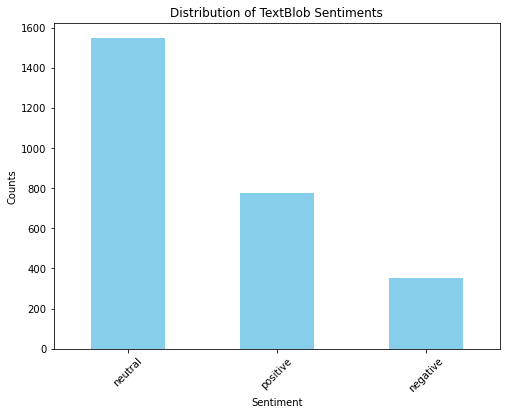

In [119]:
# Get value counts
sentiment_counts = english_df['TextBlob_Sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of TextBlob Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotates the x-axis labels to avoid overlapping
plt.show()


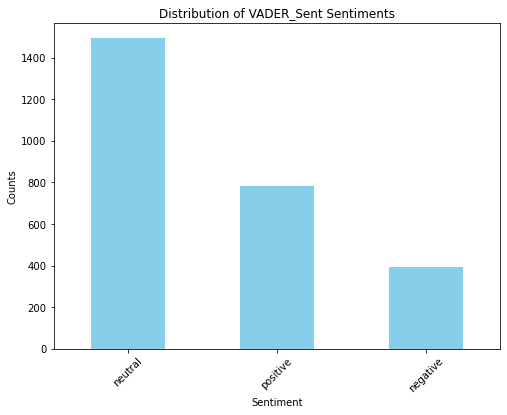

In [121]:
# Get value counts
sentiment_counts = english_df['VADER_Sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of VADER_Sent Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotates the x-axis labels to avoid overlapping
plt.show()

In [122]:
english_df.to_csv('English_Prompt_Data.csv')